In [1]:
#|default_exp conv

In [2]:
#|export
import torch
from torch import nn

from torch.utils.data import default_collate
from typing import Mapping

from miniai.training import *
from miniai.datasets import *

In [24]:
import pickle
import gzip
import math
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
from torch import tensor, nn
import torch.nn.functional as F

In [4]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

In [5]:
x_train.shape

torch.Size([50000, 784])

In [6]:
x_imgs = x_train.view(-1,28,28)
xv_imgs = x_valid.view(-1,28,28)

In [7]:
matplotlib.rcParams['figure.dpi'] = 50
matplotlib.rcParams['image.cmap'] = 'gray'

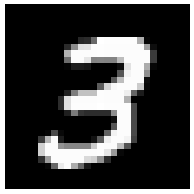

In [8]:
im3 = x_imgs[7]
show_image(im3);

In [9]:
inp = im3[None,None,:,:].float()

In [10]:
top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

In [11]:
left_edge = tensor([[-1,0,1],
                    [-1,0,1],
                    [-1,0,1]]).float()

In [12]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

In [13]:
diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

In [14]:
conv = F.conv2d(inp, top_edge[None,None])

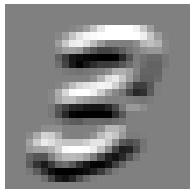

In [15]:
show_image(conv.squeeze());

In [16]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])[:,None]
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [17]:
xb = x_imgs[:16][:,None]
xb.shape

torch.Size([16, 1, 28, 28])

In [18]:
convs = F.conv2d(xb, edge_kernels)

In [19]:
convs.shape

torch.Size([16, 4, 26, 26])

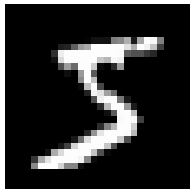

In [20]:
img0 = xb[0]
show_image(img0);

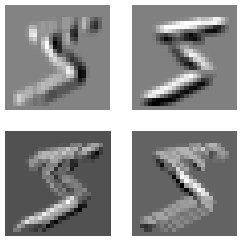

In [21]:
show_images([convs[0,i] for i in range(4)])

#### Build the CNN

In [23]:
n,m = x_train.shape
c = y_train.max()+1

In [33]:
#| export
def conv(ni, nf, ks=3, stride=2, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [34]:
conv_layer = conv(1, 4)

In [35]:
conv_layer(xb).shape

torch.Size([16, 4, 14, 14])

In [101]:
simple_cnn = nn.Sequential(
    conv(1,4),              #14x14
    conv(4,8),              #7x7
    conv(8,16),             #4x4
    conv(16,16),            #2x2
    conv(16,10, act=False), #1x1
    nn.Flatten()
)

In [102]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [103]:
x_imgs = x_train.view(-1, 1, 28, 28)
xv_imgs = x_valid.view(-1, 1, 28, 28)

In [104]:
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xv_imgs, y_valid)

In [105]:
train_ds[:3][0].shape

torch.Size([3, 1, 28, 28])

In [106]:
d = {'e': 5}
dd = [1,2]
isinstance(d, Mapping), isinstance(dd, Mapping)

(True, False)

In [107]:
x = [torch.tensor([[1,2],[3,4]]), 'at']

In [108]:
type(x)(o for o in x)

[tensor([[1, 2],
         [3, 4]]),
 'at']

In [109]:
#| export
def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, Mapping): {k:v.to(device) for k,v in x.items()}
    return type(x)(o.to(device) for o in x)

def collate_device(b): return to_device(default_collate(b))

In [110]:
from torch import optim

In [113]:
bs = 256
lr = 0.4
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs, collate_fn=collate_device)

In [114]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [115]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.39088879804611204 0.8885999996185303
1 0.17997179322242737 0.9464000003814698
2 0.17829024684429168 0.943699999332428
3 0.16307286472320556 0.9534999992370605
4 0.13338019649982452 0.9588000005722046


In [116]:
opt = optim.SGD(simple_cnn.parameters(), lr=lr/4)

In [117]:
loss, acc = fit(5, simple_cnn.to(def_device), F.cross_entropy, opt, train_dl, valid_dl)

0 0.08492271656990051 0.9759999994277954
1 0.08389791004657746 0.9757999994277954
2 0.07974473614692688 0.9763999995231628
3 0.07951399259567261 0.9769999994277954
4 0.08151660356521606 0.9757999995231629


In [100]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
#             print(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [85]:
a = torch.tensor([[1,2,3,4,10,4,3,2,1,2,3,4]]).float()
b = torch.tensor([0])
F.cross_entropy(a,b)

tensor(9.0114)